In [28]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import altair as alt

%matplotlib inline
plt.style.use('ggplot')

#Librerías para modelos

from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix, precision_score

#Para representar el arbol

import pydotplus
from IPython.display import Image
from sklearn import tree
import graphviz     #conda install python-graphviz

In [2]:
path='/Users/blancabengoa/Desktop/KSchool/TFM/Modelo3/'

In [3]:
X_train = pickle.load(open(path + "X_train.pkl","rb"))
X_test = pickle.load(open(path + "X_test.pkl","rb"))
y_train = pickle.load(open(path + "y_train.pkl","rb"))
y_test = pickle.load(open(path + "y_test.pkl","rb"))

In [12]:
attributes_column=X_train.columns

In [14]:
model=pickle.load(open(path + "clfxb_3.pkl","rb"))

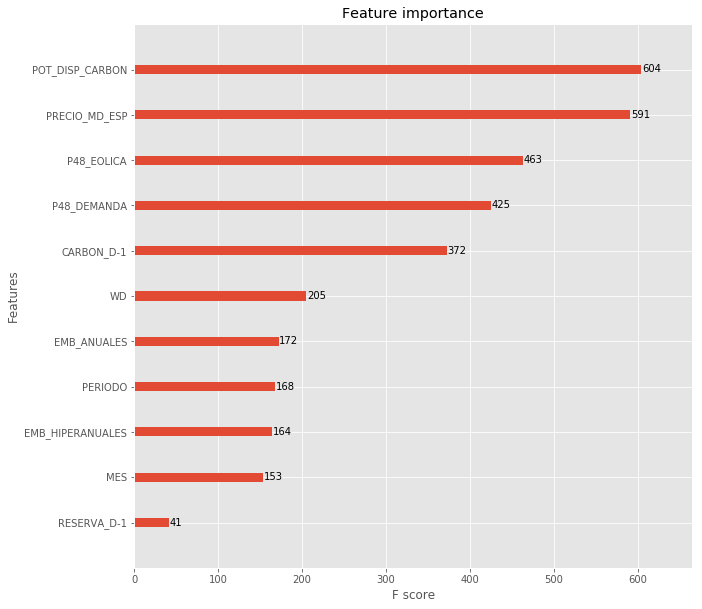

In [15]:
plot_importance(model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [17]:
accuracy_score(y_test,model.predict(X_test))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7040525114155252

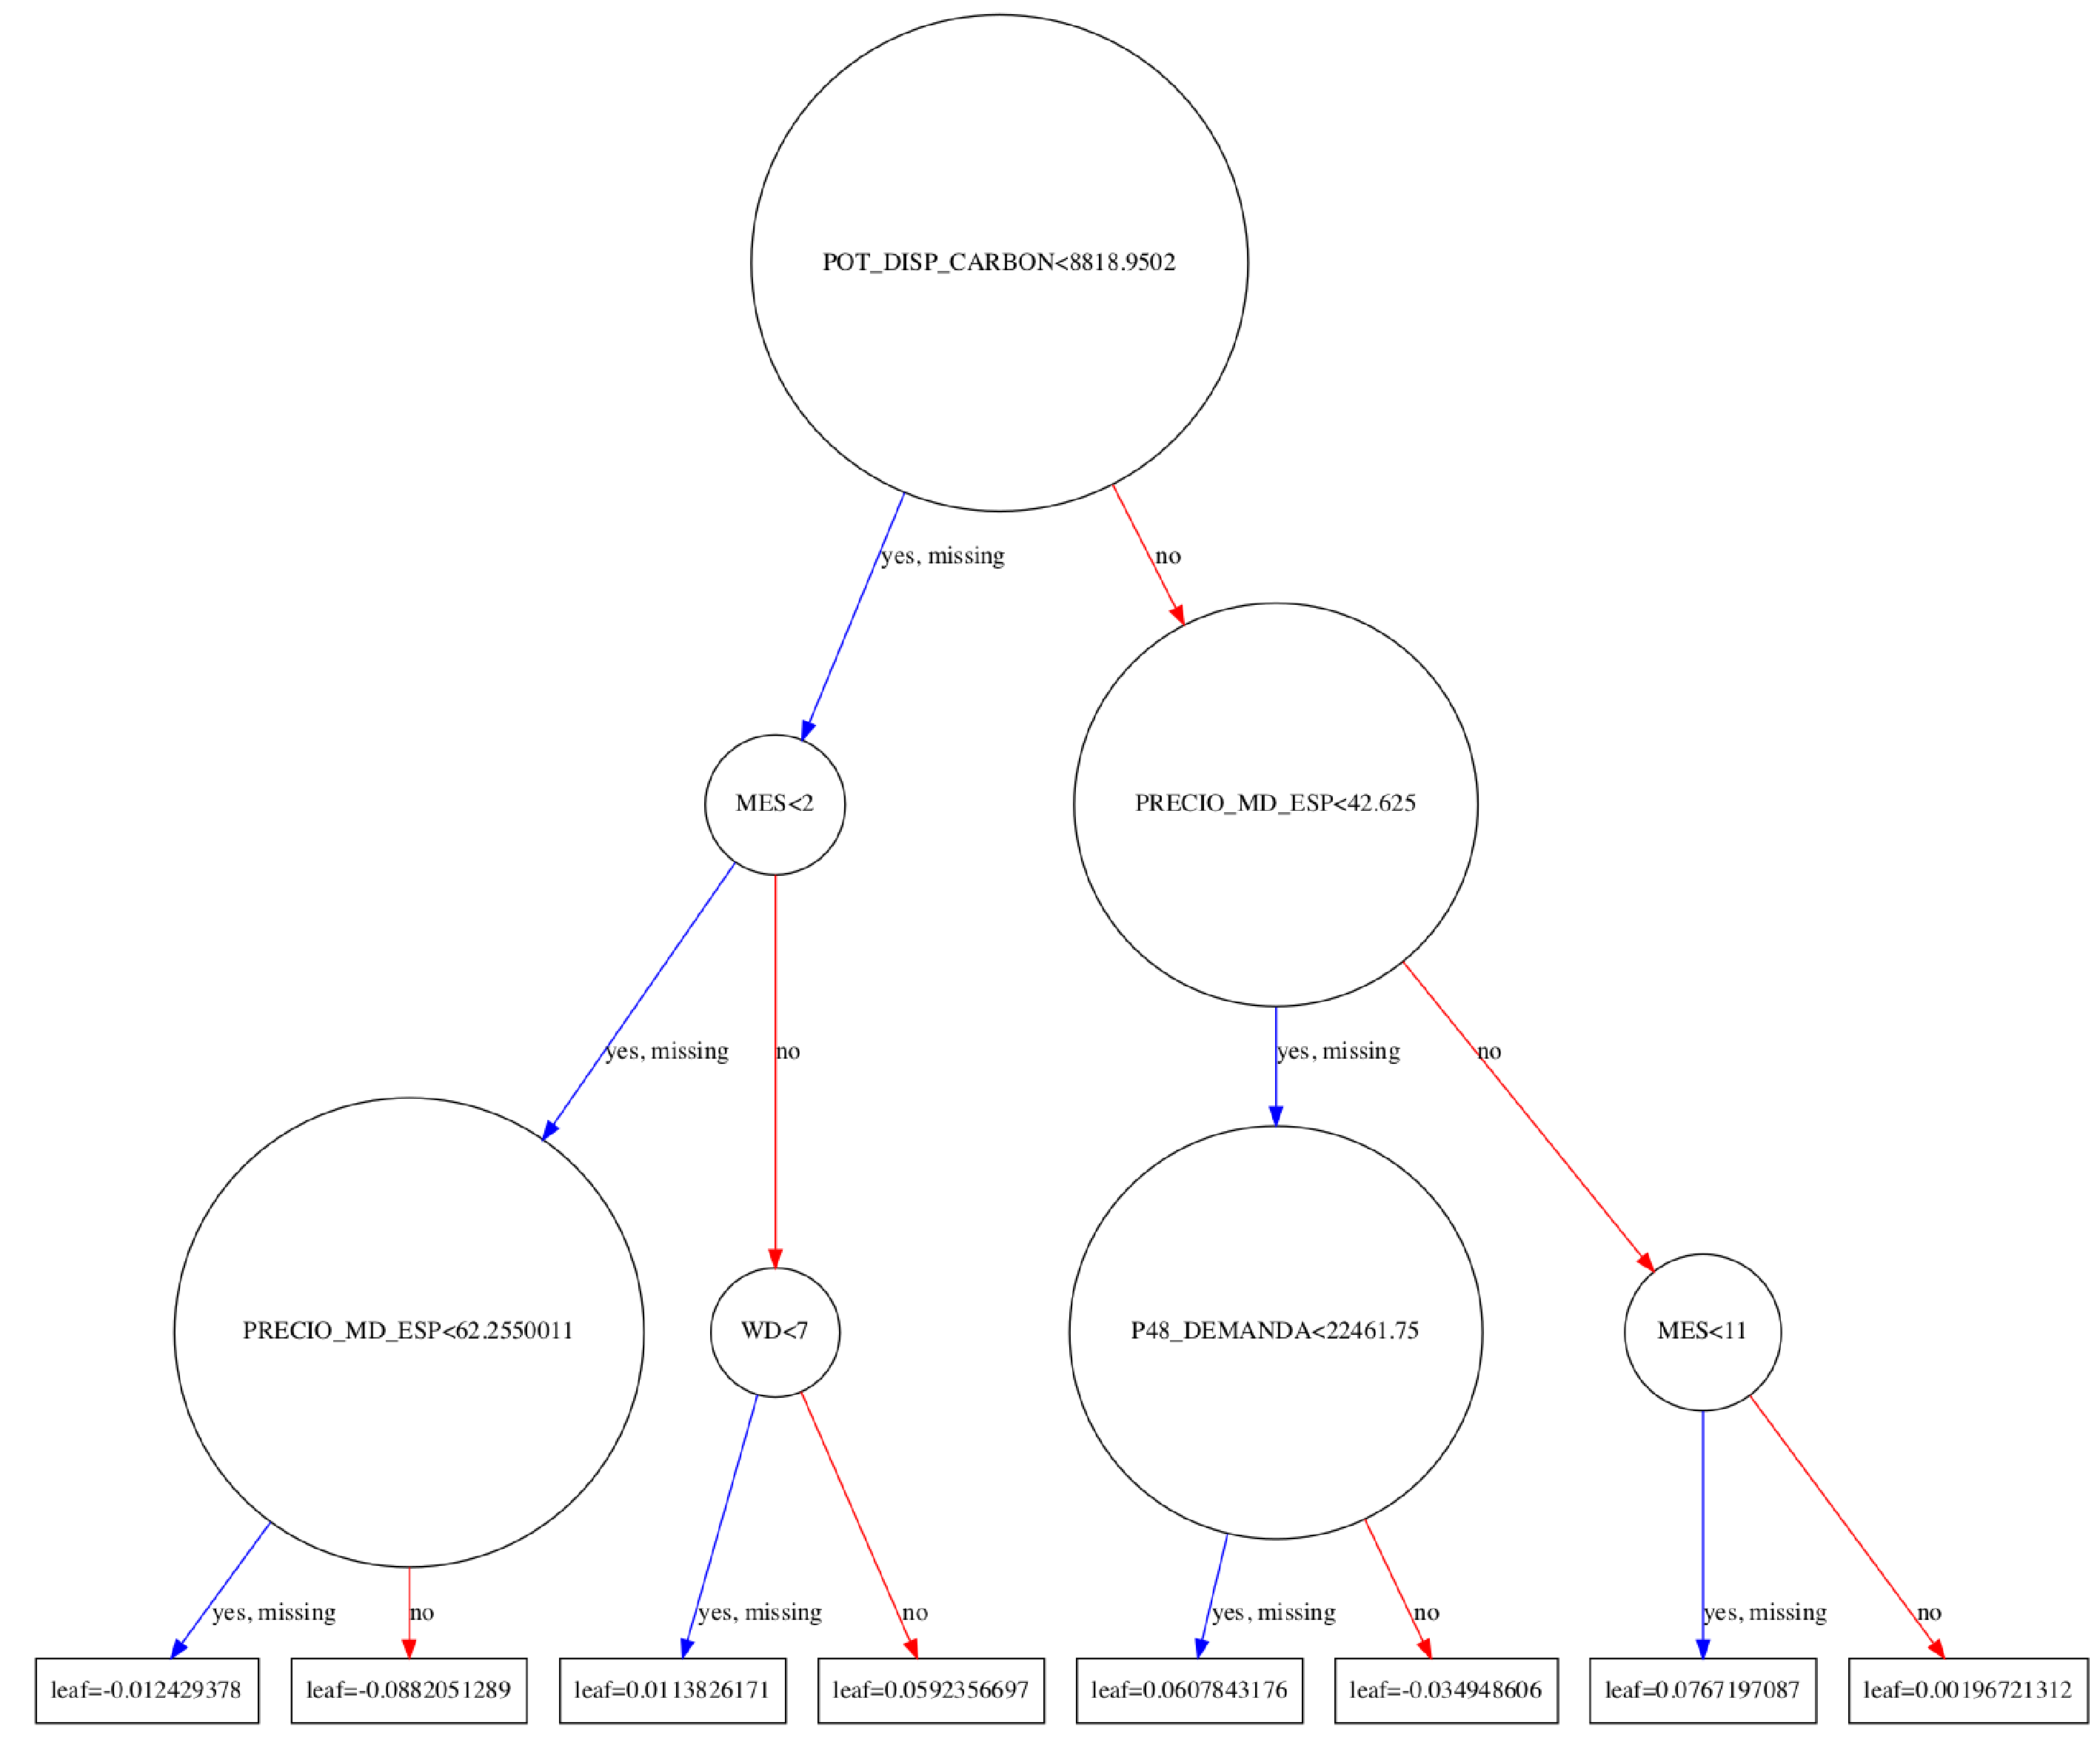

In [37]:
plot_tree(model)
plt.rcParams['figure.figsize'] = [40, 40]
plt.show()

In [45]:
prob=list(model.predict_proba(X_test))
pred=list(model.predict(X_test))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [50]:
df=pd.DataFrame(prob,columns=['PROB_0','PROB_1'])

In [51]:
df.head()

,PROB_0,PROB_1
0,0.561450,0.438550
1,0.518855,0.481145
2,0.570224,0.429776
3,0.517602,0.482398
4,0.239380,0.760620


In [69]:
df['PRED']=pred
df['TRUE']=list(y_test)

In [70]:
df.head()

,PROB_0,PROB_1,PRED,TRUE
0,0.561450,0.438550,0,1
1,0.518855,0.481145,0,1
2,0.570224,0.429776,0,0
3,0.517602,0.482398,0,1
4,0.239380,0.760620,1,1


In [78]:
BAJA_INTRA=df[df['TRUE']==1].copy()
SUBE_INTRA=df[df['TRUE']==0].copy()

In [79]:
BAJA_INTRA[BAJA_INTRA['PRED']==1]['PROB_1'].describe()

count    1631.000000
mean        0.707482
std         0.109776
min         0.500265
25%         0.621405
50%         0.704190
75%         0.792525
max         0.984472
Name: PROB_1, dtype: float64

In [80]:
BAJA_INTRA[BAJA_INTRA['PRED']==1]['PROB_0'].describe()

count    1631.000000
mean        0.292518
std         0.109776
min         0.015528
25%         0.207475
50%         0.295810
75%         0.378595
max         0.499735
Name: PROB_0, dtype: float64

In [81]:
SUBE_INTRA[SUBE_INTRA['PRED']==1]['PROB_1'].describe()

count    682.000000
mean       0.632622
std        0.090890
min        0.500005
25%        0.559389
50%        0.618044
75%        0.688087
max        0.894395
Name: PROB_1, dtype: float64

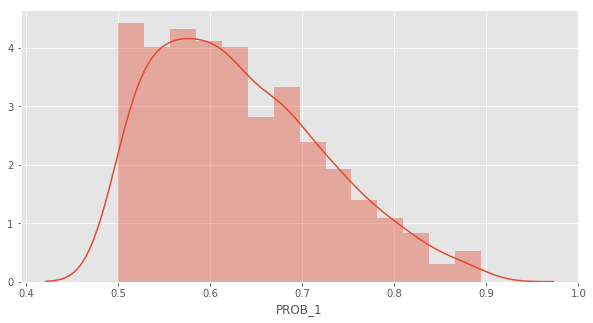

In [95]:
plt.figure(figsize=(10,5))
sns.distplot(SUBE_INTRA[SUBE_INTRA['PRED']==1]['PROB_1']);

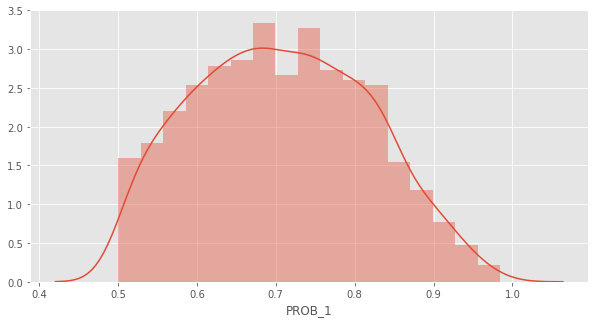

In [98]:
plt.figure(figsize=(10,5))
sns.distplot(BAJA_INTRA[BAJA_INTRA['PRED']==1]['PROB_1']);